In [1]:
using Muon
using Plots
using StatsPlots
using NearestNeighbors
using Distances

# Functions

In [2]:
function intrinsic_stability(adata; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    celltype_cosine_similarity = Array{Array}(undef, 0)
    for label in labels
        temp_velocity_projection = velocity_projection[:, celltype .== label]
        temp_embedding = embedding[:, celltype .== label]

        kdTree = KDTree(temp_embedding)

        cell_cosine_similarity = Array{Float32}(undef, 0)
        for i in axes(temp_embedding, 2)
            idxs, _ = knn(kdTree, temp_embedding[:, i], n_neighbors + 1, true)
            idxs = idxs[2:end]
            cos_sim = []
            for j in axes(idxs, 1)
                if ~isnan(cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                    push!(cos_sim, 1 - cosine_dist(temp_velocity_projection[:, i], temp_velocity_projection[:, idxs[j]]))
                end
            end
            if ~isempty(cos_sim)
                cos_sim = sum(cos_sim) / length(cos_sim)
                push!(cell_cosine_similarity, cos_sim)
            end
        end

        push!(celltype_cosine_similarity, cell_cosine_similarity)
    end

    celltype_intrinsic_stability = Dict(k => v for (k, v) in zip(labels, celltype_cosine_similarity))

    return celltype_intrinsic_stability
end

intrinsic_stability (generic function with 1 method)

In [3]:
function extrinsic_stability(adata, differentiation_direction; xkey = "X_ebd", vkey = "velocity_ebd", celltype = "clusters", n_neighbors = 30)
    celltype_extrinsic_stability = Dict(item => Array{Float32}(undef, 0) for item in keys(differentiation_direction))
    
    celltype = adata.obs[!, celltype]
    labels = sort(unique(celltype))
    velocity_projection = adata.obsm[vkey]'
    embedding = adata.obsm[xkey]'

    kdTree = KDTree(embedding)

    for i in axes(embedding, 2)
        idxs, _ = knn(kdTree, embedding[:, i], n_neighbors + 1, true)
        idxs = idxs[2:end]

        if ~haskey(celltype_extrinsic_stability, celltype[i])
            continue
        end

        if typeof(differentiation_direction[celltype[i]]) == Vector{String}
            if length(findall(x -> x in differentiation_direction[celltype[i]], celltype[idxs])) == 0
                continue
            end
        elseif ~(differentiation_direction[celltype[i]] in celltype[idxs])
            continue
        end

        temp_cos_sim = []
        X̂ = embedding[:, idxs] .- embedding[:, i]

        for j in axes(X̂, 2)
            if typeof(differentiation_direction[celltype[i]]) == Vector{String}
                if celltype[idxs[j]] in differentiation_direction[celltype[i]]
                    push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
                end
            else
                if celltype[idxs[j]] == differentiation_direction[celltype[i]]
                    push!(temp_cos_sim, 1 - cosine_dist(X̂[:, j], velocity_projection[:, i]))
                end
            end
        end

        temp_cos_sim = filter(isfinite, temp_cos_sim)
        if ~isempty(temp_cos_sim)
            temp_cos_sim = sum(temp_cos_sim) / length(temp_cos_sim)
            push!(celltype_extrinsic_stability[celltype[i]], temp_cos_sim)
        end
    end

    return celltype_extrinsic_stability
end

extrinsic_stability (generic function with 1 method)

In [4]:
function merge_for_boxplot(julovelo, scvelo, deepvelo, celldancer, julovelo_multiome, labels)
    X = Array{Float32}(undef, 0)
    models = Array{Float32}(undef, 0)
    groups = Array{Float32}(undef, 0)

    for label in labels
        x = vcat(
            julovelo[label], 
            scvelo[label], 
            deepvelo[label], 
            celldancer[label],
            julovelo_multiome[label]
        )
        model = vcat(
            ["JuloVelo_GEX" for i in 1:length(julovelo[label])],
            ["scVelo" for i in 1:length(scvelo[label])],
            ["DeepVelo" for i in 1:length(deepvelo[label])],
            ["cellDancer" for i in 1:length(celldancer[label])],
            ["JuloVelo_multiome" for i in 1:length(julovelo_multiome[label])]
        )
        group = [label for i in 1:length(model)]

        X = vcat(X, x)
        models = vcat(models, model)
        groups = vcat(groups, group)
    end

    return X, models, groups
end

merge_for_boxplot (generic function with 1 method)

# Differentiation flow

In [5]:
differentiation_direction = Dict(
    "IPC" => ["RG, Astro, OPC", "V-SVZ", "Ependymal cells"],
    "V-SVZ" => ["Upper Layer", "Subplate"],
    "Ependymal cells" => "Deeper Layer",
    "Subplate" => "Deeper Layer",
    "Upper Layer" => "Deeper Layer"
)

Dict{String, Any} with 5 entries:
  "IPC"             => ["RG, Astro, OPC", "V-SVZ", "Ependymal cells"]
  "Subplate"        => "Deeper Layer"
  "V-SVZ"           => ["Upper Layer", "Subplate"]
  "Ependymal cells" => "Deeper Layer"
  "Upper Layer"     => "Deeper Layer"

# Load data

In [6]:
theme(:vibrant, framestyle = :axes, grid = true, markersize = 3, linewidth = 1.4, palette = :tab20) 

In [7]:
julovelo_adata = readh5ad("GEX/data/JuloVelo.h5ad")
scvelo_adata = readh5ad("GEX/data/scvelo.h5ad")
deepvelo_adata = readh5ad("GEX/data/deepvelo.h5ad")
celldancer_adata = readh5ad("GEX/data/celldancer.h5ad")
multi_julovelo_adata = readh5ad("Multiome/data/JuloVelo.h5ad")

AnnData object 3644 ✕ 1959

In [22]:
intrinsic_labels = sort(unique(julovelo_adata.obs.celltype))

7-element Vector{String}:
 "Deeper Layer"
 "Ependymal cells"
 "IPC"
 "RG, Astro, OPC"
 "Subplate"
 "Upper Layer"
 "V-SVZ"

In [23]:
extrinsic_labels = [item for item in intrinsic_labels if item in keys(differentiation_direction)]

5-element Vector{String}:
 "Ependymal cells"
 "IPC"
 "Subplate"
 "Upper Layer"
 "V-SVZ"

In [24]:
intrinsic_palettes = Dict(
    "Deeper Layer"=>"#1f77b4",
    "Ependymal cells"=>"#ff7f0e",
    "IPC"=>"#2ca02c",
    "RG, Astro, OPC"=>"#d62728",
    "Subplate"=>"#9467bd",
    "Upper Layer"=>"#8c564b",
    "V-SVZ"=>"#e377c2"
)

Dict{String, String} with 7 entries:
  "Deeper Layer"    => "#1f77b4"
  "IPC"             => "#2ca02c"
  "RG, Astro, OPC"  => "#d62728"
  "Subplate"        => "#9467bd"
  "V-SVZ"           => "#e377c2"
  "Ependymal cells" => "#ff7f0e"
  "Upper Layer"     => "#8c564b"

In [25]:
extrinsic_palettes = Dict(
    "Ependymal cells"=>"#ff7f0e",
    "IPC"=>"#2ca02c",
    "Subplate"=>"#9467bd",
    "Upper Layer"=>"#8c564b",
    "V-SVZ"=>"#e377c2"
)

Dict{String, String} with 5 entries:
  "IPC"             => "#2ca02c"
  "Subplate"        => "#9467bd"
  "V-SVZ"           => "#e377c2"
  "Ependymal cells" => "#ff7f0e"
  "Upper Layer"     => "#8c564b"

In [26]:
intrinsic_colors = [intrinsic_palettes[label] for label in intrinsic_labels]
intrinsic_colors = reshape([parse(Colorant, item) for item in intrinsic_colors], 1, :)

In [27]:
extrinsic_colors = [extrinsic_palettes[label] for label in extrinsic_labels]
extrinsic_colors = reshape([parse(Colorant, item) for item in extrinsic_colors], 1, :)

# Intrinsic stability

In [28]:
julovelo_intrinsic_stability = intrinsic_stability(julovelo_adata; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
scvelo_intrinsic_stability = intrinsic_stability(scvelo_adata; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
deepvelo_intrinsic_stability = intrinsic_stability(deepvelo_adata; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
celldancer_intrinsic_stability = intrinsic_stability(celldancer_adata; xkey = "X_cdr", vkey = "velocity_cdr")
julovelo_multiome_intrinsic_stability = intrinsic_stability(multi_julovelo_adata; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")

Dict{String, Vector{Float32}} with 7 entries:
  "Deeper Layer"    => [0.91648, 0.199407, 0.790609, 0.948085, 0.928302, 0.9863…
  "IPC"             => [0.376035, 0.976713, 0.816908, 0.411462, 0.798425, 0.969…
  "RG, Astro, OPC"  => [0.982541, 0.993403, 0.537716, 0.869419, 0.283421, 0.864…
  "Subplate"        => [0.911568, 0.712328, 0.948949, 0.97112, 0.992345, 0.8867…
  "V-SVZ"           => [0.97561, 0.982357, 0.959163, 0.893798, 0.813087, 0.9647…
  "Ependymal cells" => [0.979061, 0.583756, 0.95866, 0.980845, 0.971773, 0.9856…
  "Upper Layer"     => [0.988977, 0.945356, 0.959618, 0.964819, 0.986681, 0.992…

In [29]:
in_X, in_models, in_groups = merge_for_boxplot(julovelo_intrinsic_stability, scvelo_intrinsic_stability, deepvelo_intrinsic_stability, celldancer_intrinsic_stability, julovelo_multiome_intrinsic_stability, intrinsic_labels)

(Float32[0.96984184, 0.48910704, 0.75835556, 0.79604965, 0.8981396, 0.97641563, 0.5620299, 0.97949, 0.8394964, 0.8343937  …  0.85543865, 0.93992716, 0.9764267, 0.9690481, 0.8790463, 0.9511595, 0.88031155, 0.9757794, 0.83471537, 0.8862474], Any["JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX"  …  "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome"], Any["Deeper Layer", "Deeper Layer", "Deeper Layer", "Deeper Layer", "Deeper Layer", "Deeper Layer", "Deeper Layer", "Deeper Layer", "Deeper Layer", "Deeper Layer"  …  "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ"])

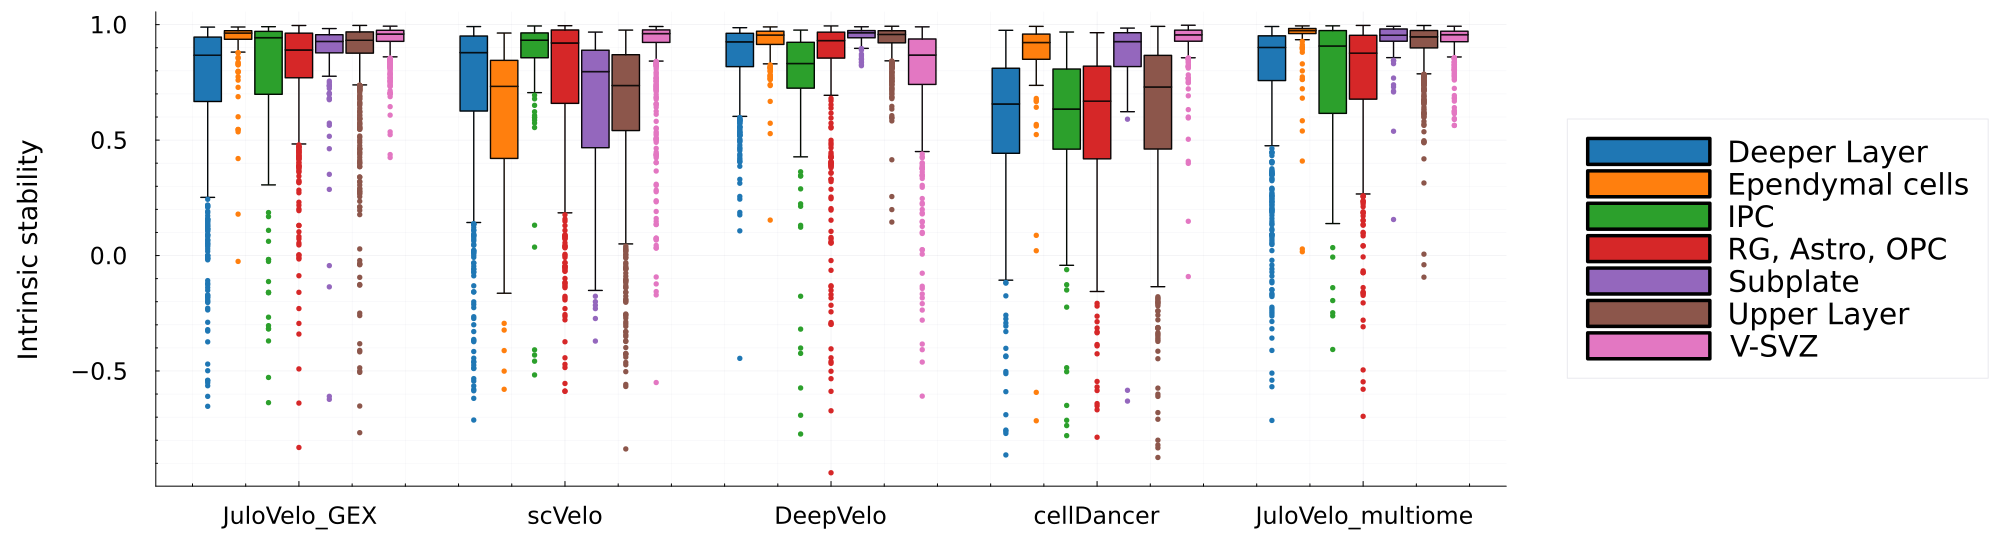

In [30]:
p = groupedboxplot(in_models, in_X, group = in_groups, size = (2000, 550), color = intrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Intrinsic stability"
)

In [31]:
savefig(p, "mouse_brain_intrinsic_stability.png")

"/media/data/bmi111/KuanChiun/JuloVelo/thesis/results/Mouse_E18/mouse_brain_intrinsic_stability.png"

# Extrinsic stability

In [32]:
julovelo_extrinsic_stability = extrinsic_stability(julovelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
scvelo_extrinsic_stability = extrinsic_stability(scvelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
deepvelo_extrinsic_stability = extrinsic_stability(deepvelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")
celldancer_extrinsic_stability = extrinsic_stability(celldancer_adata, differentiation_direction; xkey = "X_cdr", vkey = "velocity_cdr")
julovelo_multiome_extrinsic_stability = extrinsic_stability(multi_julovelo_adata, differentiation_direction; xkey = "X_umap", vkey = "velocity_umap", celltype = "celltype")

Dict{String, Vector{Float32}} with 5 entries:
  "IPC"             => [0.295774, 0.942917, -0.8446, 0.253778, -0.92982, -0.998…
  "Subplate"        => [-0.974511, -0.998377, 0.374421, 0.243013, 0.481025, 0.3…
  "V-SVZ"           => [-0.508619, 0.698954, 0.182592, 0.405467, 0.00185086, 0.…
  "Ependymal cells" => [0.959112, 0.644761, -0.988097, 0.74258, 0.897198, -0.46…
  "Upper Layer"     => [0.10173, -0.985123, 0.572815, -0.0843232, 0.994341, -0.…

In [33]:
ex_X, ex_models, ex_groups = merge_for_boxplot(julovelo_extrinsic_stability, scvelo_extrinsic_stability, deepvelo_extrinsic_stability, celldancer_extrinsic_stability, julovelo_multiome_extrinsic_stability, extrinsic_labels)

(Float32[0.7883123, 0.9591491, -0.18400265, 0.71873343, 0.62245226, 0.640243, 0.8106337, 0.73263294, 0.65398467, 0.9730123  …  0.81672686, -0.07638738, -0.16032527, 0.2052689, -0.5750112, 0.112703726, 0.44661856, -0.17431554, -0.0021919543, 0.7333879], Any["JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX", "JuloVelo_GEX"  …  "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome", "JuloVelo_multiome"], Any["Ependymal cells", "Ependymal cells", "Ependymal cells", "Ependymal cells", "Ependymal cells", "Ependymal cells", "Ependymal cells", "Ependymal cells", "Ependymal cells", "Ependymal cells"  …  "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ", "V-SVZ"])

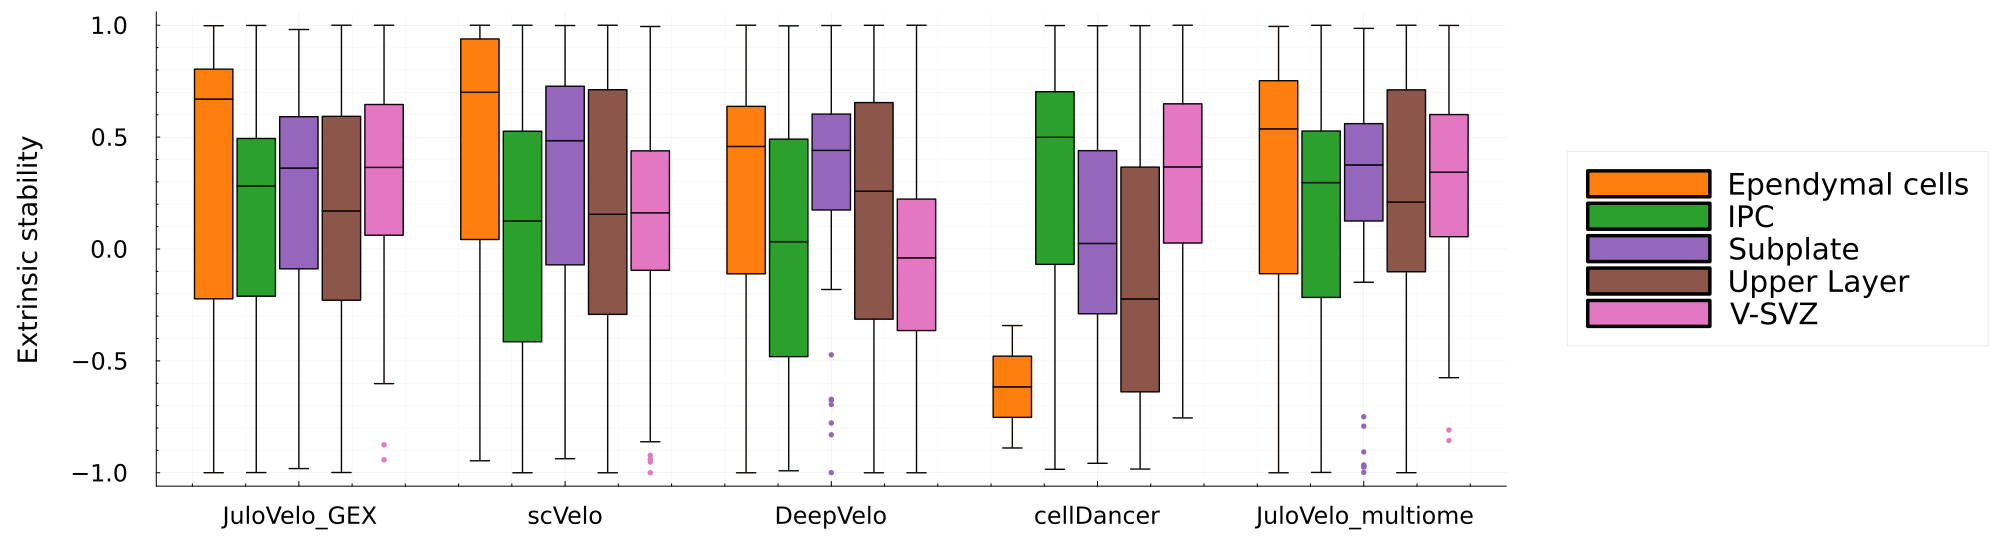

In [34]:
p = groupedboxplot(ex_models, ex_X, group = ex_groups, size = (2000, 550), color = extrinsic_colors, legend = :outerright,
    tickfontsize = 16, guidefontsize = 18, left_margin = 1.5Plots.cm, bottom_margin = 1.0Plots.cm, legendfontsize = 20, ylabel = "Extrinsic stability"
)

In [35]:
savefig(p, "mouse_brain_extrinsic_stability.png")

"/media/data/bmi111/KuanChiun/JuloVelo/thesis/results/Mouse_E18/mouse_brain_extrinsic_stability.png"